In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from skimage import color, graph, io
from skimage.util import img_as_float64
from skimage.segmentation import mark_boundaries
from skimage.transform import rescale

from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth

import os.path as osp

In [2]:
def extract_feat(image: np.ndarray, color_model: str = 'RGB') -> pd.DataFrame:
    image_data = np.ndarray((image.shape[0] * image.shape[1], 5))
    for i, row in enumerate(image):
        for j, value in enumerate(row):
            image_data[i * image.shape[1] + j] = [*value, i, j]
    return pd.DataFrame(image_data, columns=[*color_model, 'x', 'y']).\
           astype({'x': 'int64', 'y': 'int64'})

def label_image(flattened_image: pd.DataFrame, labels: np.ndarray) -> np.ndarray:
    max_x = int(flattened_image.max()['x'])
    max_y = int(flattened_image.max()['y'])
    image_labels = np.ndarray((max_x + 1, max_y + 1), dtype=np.int64)
    for i, row in flattened_image.iterrows():
        image_labels[int(row['x']), int(row['y'])] = labels[i]
    return image_labels


def label_to_rgb(image, labels, boundaries = True):
    result = color.label2rgb(labels, image,
                             kind='avg', bg_label=-1,
                             image_alpha=0, alpha=1)
    if boundaries: result = mark_boundaries(result, labels)
    return result

def show_ax(ax, title, image):
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(title, fontsize=12)
    return ax

(321, 481, 3)


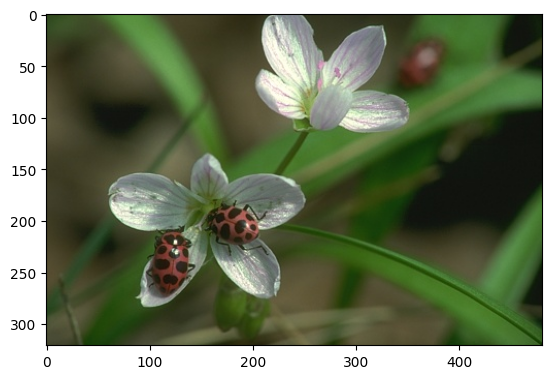

In [3]:
image_name = '35008'

image = io.imread(osp.join('.', 'Dataset', 'Image', f'{image_name}.jpg'))
print(image.shape)
plt.imshow(image)

In [4]:
transformed_image = img_as_float64(color.rgb2hsv(image))
hsv_df = extract_feat(transformed_image, 'HSV')
rgb_df = extract_feat(img_as_float64(image), 'RGB')

# Training

## Mean Shift

### Bandwidth Estimation

Rescale image - subsampling for faster estimation

(160, 240, 3)


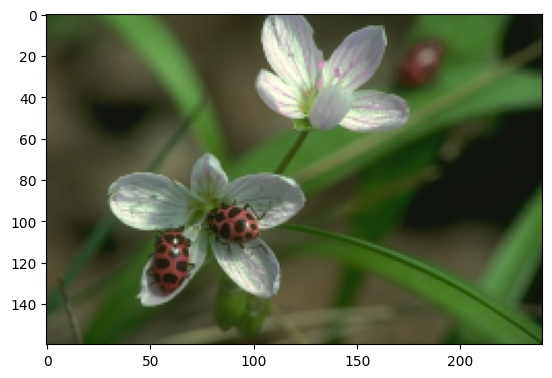

In [5]:
rescale_image = rescale(image, [0.5, 0.5, 1])
print(rescale_image.shape)
plt.imshow(rescale_image)

In [6]:
temp_df1 = extract_feat(img_as_float64(rescale_image), 'RGB')
temp_df2 = extract_feat(img_as_float64(color.rgb2hsv(rescale_image)), 'HSV')
# sub_samples = int(temp_df.shape[0] * .)
bandwidths = {'rgb': estimate_bandwidth(temp_df1[[*'RGB']], quantile=.2, random_state=0, n_jobs=-1),
              'hsv': estimate_bandwidth(temp_df2[[*'HSV']], quantile=.2, random_state=0, n_jobs=-1)}
bandwidths

{'rgb': np.float64(0.17247882483795846),
 'hsv': np.float64(0.20756949358321444)}

### Train

In [7]:
mean_shift_result = {}
ms_model = MeanShift(bin_seeding=True, max_iter=1000, cluster_all=True, n_jobs=-1)

In [8]:
ms_model.set_params(bandwidth=bandwidths['rgb'])
train = rgb_df[[*'RGB']]
temp = ms_model.fit_predict(train)

rgb_result = {'clustering': temp,
              'labeled_image': label_image(rgb_df, temp),
              'k_clusters': len(ms_model.cluster_centers_)}
mean_shift_result['rgb'] = rgb_result

print('clusters:', rgb_result['k_clusters'])
rgb_result['labeled_image']

clusters: 2


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
ms_model.set_params(bandwidth=bandwidths['hsv'])
train = hsv_df[[*'HSV']]
temp = ms_model.fit_predict(train)

hsv_result = {'clustering': temp,
              'labeled_image': label_image(hsv_df, temp),
              'k_clusters': len(ms_model.cluster_centers_)}
mean_shift_result['hsv'] = hsv_result

print('clusters:', hsv_result['k_clusters'])
hsv_result['labeled_image']

clusters: 3


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## K-Means

In [10]:
kmean_result = {}
km_model = KMeans(random_state=0, max_iter=1000)

In [11]:
km_model.set_params(n_clusters=mean_shift_result['rgb']['k_clusters'])
train = rgb_df[[*'RGB']]
temp = km_model.fit_predict(train)

rgb_result = {'clustering': temp,
              'labeled_image': label_image(rgb_df, temp),
              'k_clusters': mean_shift_result['rgb']['k_clusters']}
kmean_result['rgb'] = rgb_result

print('clusters:', rgb_result['k_clusters'])
rgb_result['labeled_image']

clusters: 2


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [12]:
km_model.set_params(n_clusters=mean_shift_result['hsv']['k_clusters'])
train = hsv_df[[*'HSV']]
temp = km_model.fit_predict(train)

hsv_result = {'clustering': temp,
              'labeled_image': label_image(hsv_df, temp),
              'k_clusters': mean_shift_result['hsv']['k_clusters']}
kmean_result['hsv'] = hsv_result

print('clusters:', hsv_result['k_clusters'])
hsv_result['labeled_image']

clusters: 3


array([[1, 1, 1, ..., 1, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1]])

# Post-process

In [13]:
# merge functions are provided by skimage, for more information, please visit
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_merge.html#sphx-glr-auto-examples-segmentation-plot-rag-merge-py
def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}


def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (
        graph.nodes[dst]['total color'] / graph.nodes[dst]['pixel count']
    )

In [14]:
ms_rags = [graph.rag_mean_color(transformed_image, mean_shift_result['rgb']['labeled_image'], mode='distance'),
           graph.rag_mean_color(transformed_image, mean_shift_result['hsv']['labeled_image'], mode='distance')]
km_rags = [graph.rag_mean_color(transformed_image, kmean_result['rgb']['labeled_image'], mode='distance'),
           graph.rag_mean_color(transformed_image, kmean_result['hsv']['labeled_image'], mode='distance')]

In [15]:
merge_alias = lambda labels, rag, threshold: graph.merge_hierarchical(labels, rag,
                                                                      thresh=threshold, # larger thresh -> less labels
                                                                      rag_copy=True,
                                                                      in_place_merge=False,
                                                                      merge_func=merge_mean_color,
                                                                      weight_func=_weight_mean_color)

thres = .3
merged_labels = {'mean_shift': [merge_alias(mean_shift_result['rgb']['labeled_image'], ms_rags[0], thres),
                                merge_alias(mean_shift_result['hsv']['labeled_image'], ms_rags[1], thres)],
                 'kmean': [merge_alias(kmean_result['rgb']['labeled_image'], ms_rags[0], thres),
                           merge_alias(kmean_result['hsv']['labeled_image'], ms_rags[1], thres)]}

print("Mean Shift after merging (RGB | HSV):",
      f"{len(np.unique(merged_labels['mean_shift'][0]))} | {len(np.unique(merged_labels['mean_shift'][1]))} (clusters)")
print("Kmeans after merging (RGB | HSV):",
      f"{len(np.unique(merged_labels['kmean'][0]))} | {len(np.unique(merged_labels['kmean'][1]))} (clusters)")

Mean Shift after merging (RGB | HSV): 2 | 3 (clusters)
Kmeans after merging (RGB | HSV): 2 | 3 (clusters)


# Evaluation

In [16]:
from sklearn.metrics.cluster import rand_score, silhouette_samples

## Silhouette Score

Calculate silhouette coefficients

In [28]:
def draw_silhouette(ax, silhouette_coefficients, title):
    y_lower = 10
    silhouette_sum = 0
    total_sample = 0 
    for cluster in range(len(silhouette_coefficients)):
        sample_size = silhouette_coefficients[cluster].shape[0]

        silhouette_sum += np.sum(silhouette_coefficients[cluster])
        total_sample += sample_size

        y_upper = y_lower + sample_size
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_coefficients[cluster],
                         alpha=.9)
        ax.text(-0.05, y_lower + 0.5 * sample_size, str(cluster))
        
        y_lower = y_upper + 10

    sil_score = silhouette_sum / total_sample
    ax.axvline(x=sil_score, color=(1, 0, 0), linestyle='--')
    ax.text(sil_score + .01, 0, f'{sil_score:.2f}')

    ax.set_xlabel('Silhouette coefficient')
    ax.set_ylabel('Clusters')

    ax.set_yticks([])
    ax.set_title(title)

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
# sampling because silhouette coefficients takes too long for large samples
sampler = StratifiedShuffleSplit(1, train_size=.7, random_state=0)

In [19]:
silhouette_coefs = {}
for model, result in [('mean_shift', mean_shift_result), ('kmean', kmean_result)]:
    inner = {}
    for color_model, df in [('rgb', rgb_df), ('hsv', hsv_df)]:
        labels = []
        for _, row in df.iterrows():
            labels.append(result[color_model]['labeled_image'][int(row['x']), int(row['y'])])

        sampled_labels_idx, _ = next(sampler.split(df, labels))

        temp_array = np.array(labels, dtype='float64')
        temp_array = temp_array[sampled_labels_idx]

        silhouettes = silhouette_samples(df[[*color_model.upper()]].iloc[sampled_labels_idx], temp_array)
        
        inner[color_model] = []
        for label in np.unique(temp_array):
            ith_cluster = silhouettes[temp_array == label]
            ith_cluster.sort()
            inner[color_model].append(ith_cluster)
    silhouette_coefs[model] = inner

### Mean Shift

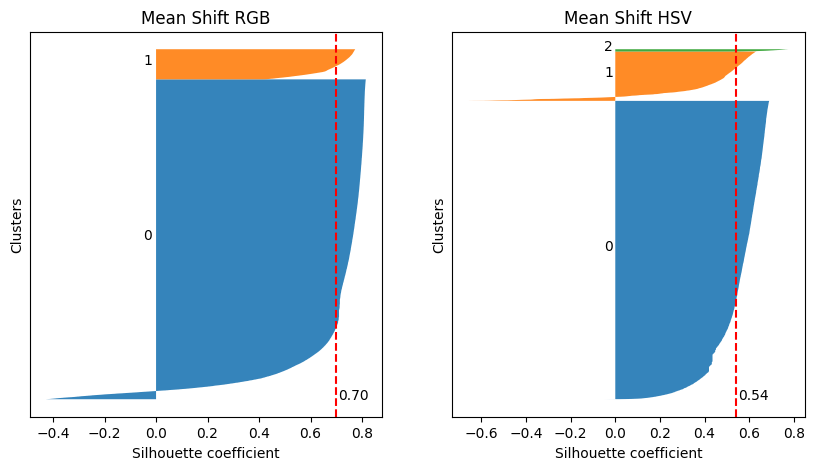

In [29]:
fig = plt.figure(figsize=(10, 5))

rgb_ax = fig.add_subplot(1, 2, 1)
hsv_ax = fig.add_subplot(1, 2, 2)

draw_silhouette(rgb_ax, silhouette_coefs['mean_shift']['rgb'], 'Mean Shift RGB')
draw_silhouette(hsv_ax, silhouette_coefs['mean_shift']['hsv'], 'Mean Shift HSV')

plt.show()

### K-Means

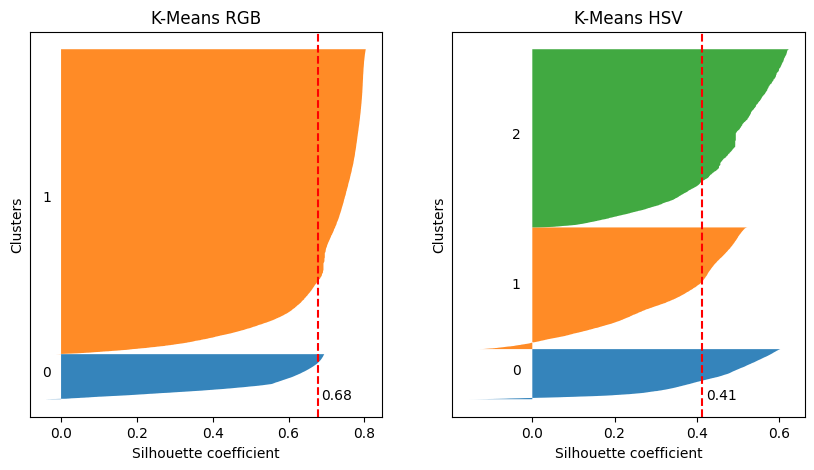

In [30]:
fig = plt.figure(figsize=(10, 5))

rgb_ax = fig.add_subplot(1, 2, 1)
hsv_ax = fig.add_subplot(1, 2, 2)

draw_silhouette(rgb_ax, silhouette_coefs['kmean']['rgb'], 'K-Means RGB')
draw_silhouette(hsv_ax, silhouette_coefs['kmean']['hsv'], 'K-Means HSV')

plt.show()

## Rand's Index

### Before Merging

Comparision between models

In [17]:
array = np.ndarray((2, 2))
array[0, 0] = rand_score(mean_shift_result['rgb']['labeled_image'].flatten(), mean_shift_result['hsv']['labeled_image'].flatten())
array[0, 1] = rand_score(mean_shift_result['rgb']['labeled_image'].flatten(), kmean_result['rgb']['labeled_image'].flatten())
array[1, 0] = rand_score(mean_shift_result['hsv']['labeled_image'].flatten(), kmean_result['hsv']['labeled_image'].flatten())
array[1, 1] = rand_score(kmean_result['rgb']['labeled_image'].flatten(), kmean_result['hsv']['labeled_image'].flatten())

rand_tab = pd.DataFrame(array, index=['Mean Shift RGB', 'K-Means HSV'], columns=['Mean Shift HSV', 'K-Means RGB'])
rand_tab

,Mean Shift HSV,K-Means RGB
Mean Shift RGB,0.884528,0.918210
K-Means HSV,0.641251,0.609264


Comparing to pre-labeled image

In [18]:
array = np.ndarray((2, 2))
mask_image = pd.read_csv(osp.join('.', 'Dataset', 'Mask', f'{image_name}.csv'), header=None)

array[0, 0] = rand_score(mean_shift_result['rgb']['labeled_image'].flatten(), mask_image.to_numpy().flatten())
array[0, 1] = rand_score(mean_shift_result['hsv']['labeled_image'].flatten(), mask_image.to_numpy().flatten())
array[1, 0] = rand_score(kmean_result['rgb']['labeled_image'].flatten(), mask_image.to_numpy().flatten())
array[1, 1] = rand_score(kmean_result['hsv']['labeled_image'].flatten(), mask_image.to_numpy().flatten())

rand_tab = pd.DataFrame(array, index=['Mean Shift', 'K-Means'], columns=['RGB as feature', 'HSV as feature'])
rand_tab

,RGB as feature,HSV as feature
Mean Shift,0.834858,0.922099
K-Means,0.888713,0.624342


### After Merging

Comparision between models

In [19]:
array = np.ndarray((2, 2))
array[0, 0] = rand_score(merged_labels['mean_shift'][0].flatten(), merged_labels['mean_shift'][1].flatten())
array[0, 1] = rand_score(merged_labels['mean_shift'][0].flatten(), merged_labels['kmean'][0].flatten())
array[1, 0] = rand_score(merged_labels['mean_shift'][1].flatten(), merged_labels['kmean'][1].flatten())
array[1, 1] = rand_score(merged_labels['kmean'][0].flatten(), merged_labels['kmean'][1].flatten())

rand_tab = pd.DataFrame(array, index=['Mean Shift RGB', 'K-Means HSV'], columns=['Mean Shift HSV', 'K-Means RGB'])
rand_tab

,Mean Shift HSV,K-Means RGB
Mean Shift RGB,0.884528,0.918210
K-Means HSV,0.641251,0.609264


Comparing to pre-labeled image

In [20]:
array = np.ndarray((2, 2))
mask_image = pd.read_csv(osp.join('.', 'Dataset', 'Mask', f'{image_name}.csv'), header=None)

array[0, 0] = rand_score(merged_labels['mean_shift'][0].flatten(), mask_image.to_numpy().flatten())
array[0, 1] = rand_score(merged_labels['mean_shift'][1].flatten(), mask_image.to_numpy().flatten())
array[1, 0] = rand_score(merged_labels['kmean'][0].flatten(), mask_image.to_numpy().flatten())
array[1, 1] = rand_score(merged_labels['kmean'][1].flatten(), mask_image.to_numpy().flatten())

rand_tab = pd.DataFrame(array, index=['Mean Shift', 'K-Means'], columns=['RGB as feature', 'HSV as feature'])
rand_tab

,RGB as feature,HSV as feature
Mean Shift,0.834858,0.922099
K-Means,0.888713,0.624342


# Visualisation

In [26]:
my_figsize = (8, 10)
do_bound = False
ms_outs = [label_to_rgb(image, mean_shift_result['rgb']['labeled_image'], boundaries=do_bound),
           label_to_rgb(image, merged_labels['mean_shift'][0], boundaries=do_bound),
           label_to_rgb(image, mean_shift_result['hsv']['labeled_image'], boundaries=do_bound),
           label_to_rgb(image, merged_labels['mean_shift'][1], boundaries=do_bound)]

km_outs = [label_to_rgb(image, kmean_result['rgb']['labeled_image'], boundaries=do_bound),
           label_to_rgb(image, merged_labels['kmean'][0], boundaries=do_bound),
           label_to_rgb(image, kmean_result['hsv']['labeled_image'], boundaries=do_bound),
           label_to_rgb(image, merged_labels['kmean'][1], boundaries=do_bound)]

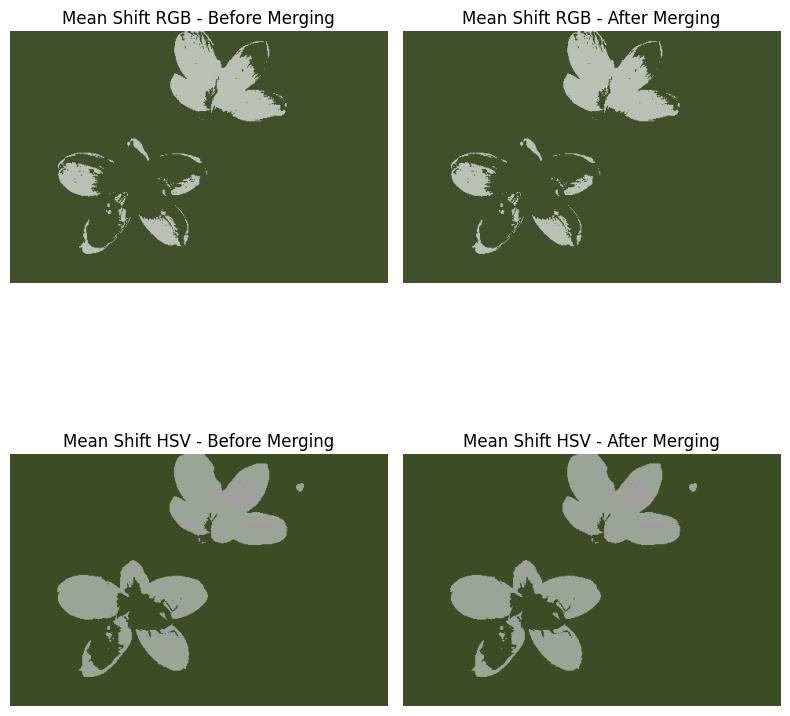

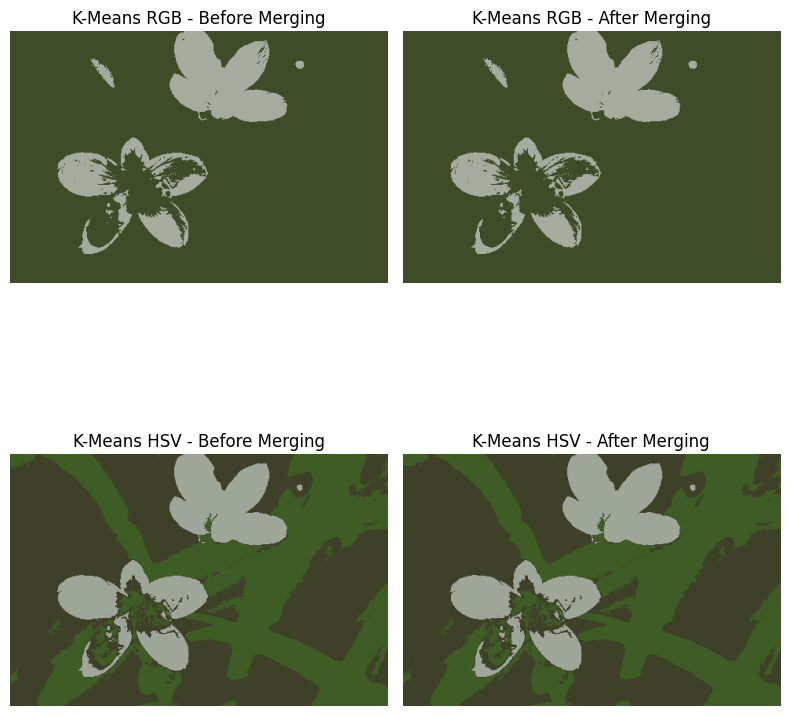

In [27]:
fig = plt.figure(figsize=my_figsize)
fig1 = plt.figure(figsize=my_figsize)

ax_msrgb1 = fig.add_subplot(2, 2, 1)
ax_msrgb2 = fig.add_subplot(2, 2, 2)
ax_mshsv1 = fig.add_subplot(2, 2, 3)
ax_mshsv2 = fig.add_subplot(2, 2, 4)

ax_kmrgb1 = fig1.add_subplot(2, 2, 1)
ax_kmrgb2 = fig1.add_subplot(2, 2, 2)
ax_kmhsv1 = fig1.add_subplot(2, 2, 3)
ax_kmhsv2 = fig1.add_subplot(2, 2, 4)


show_ax(ax_msrgb1, 'Mean Shift RGB - Before Merging', ms_outs[0])
show_ax(ax_msrgb2, 'Mean Shift RGB - After Merging', ms_outs[1])
show_ax(ax_mshsv1, 'Mean Shift HSV - Before Merging', ms_outs[2])
show_ax(ax_mshsv2, 'Mean Shift HSV - After Merging', ms_outs[3])

show_ax(ax_kmrgb1, 'K-Means RGB - Before Merging', km_outs[0])
show_ax(ax_kmrgb2, 'K-Means RGB - After Merging', km_outs[1])
show_ax(ax_kmhsv1, 'K-Means HSV - Before Merging', km_outs[2])
show_ax(ax_kmhsv2, 'K-Means HSV - After Merging', km_outs[3])

fig.tight_layout()
fig1.tight_layout()
plt.show()